In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [7]:
xle_raw = pd.read_csv('XLE.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")
xlu_raw = pd.read_csv('XLU.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")

In [8]:
xle_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-07,91.44,91.90,91.0088,91.17,15361552
2023-09-06,91.04,91.75,90.5900,91.26,20162100
2023-09-05,91.25,92.15,91.1600,91.22,24368700
2023-09-01,89.90,90.84,89.8800,90.74,17878100
2023-08-31,89.19,89.34,88.2800,88.92,14808700
...,...,...,...,...,...
2010-01-08,59.70,60.35,59.4900,60.30,13344300
2010-01-07,59.74,60.01,59.3000,59.91,17449500
2010-01-06,59.32,60.18,59.1900,60.00,24351900


In [9]:
xlu_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-07,62.35,63.13,62.19,62.63,16873800
2023-09-06,61.77,61.89,61.42,61.82,19470100
2023-09-05,62.60,62.64,61.34,61.68,18825300
2023-09-01,63.29,63.51,62.15,62.64,14387700
2023-08-31,63.82,63.88,62.94,62.96,13771100
...,...,...,...,...,...
2010-01-08,30.71,30.79,30.52,30.72,6267600
2010-01-07,30.85,30.87,30.64,30.75,6563100
2010-01-06,30.69,31.00,30.69,30.89,12745100


In [10]:
xle = xle_raw["close"].rename("XLE")
xle

datetime
2023-09-07    91.17
2023-09-06    91.26
2023-09-05    91.22
2023-09-01    90.74
2023-08-31    88.92
              ...  
2010-01-08    60.30
2010-01-07    59.91
2010-01-06    60.00
2010-01-05    59.29
2010-01-04    58.81
Name: XLE, Length: 3443, dtype: float64

In [11]:
xlu = xlu_raw["close"].rename("XLU")
xlu

datetime
2023-09-07    62.63
2023-09-06    61.82
2023-09-05    61.68
2023-09-01    62.64
2023-08-31    62.96
              ...  
2010-01-08    30.72
2010-01-07    30.75
2010-01-06    30.89
2010-01-05    30.71
2010-01-04    31.08
Name: XLU, Length: 3443, dtype: float64

In [12]:
compose = pd.merge(xle, xlu, on="datetime", how="outer")
compose

,XLE,XLU
datetime,,
2023-09-07,91.17,62.63
2023-09-06,91.26,61.82
2023-09-05,91.22,61.68
2023-09-01,90.74,62.64
2023-08-31,88.92,62.96
...,...,...
2010-01-08,60.30,30.72
2010-01-07,59.91,30.75
2010-01-06,60.00,30.89


<Axes: xlabel='datetime'>

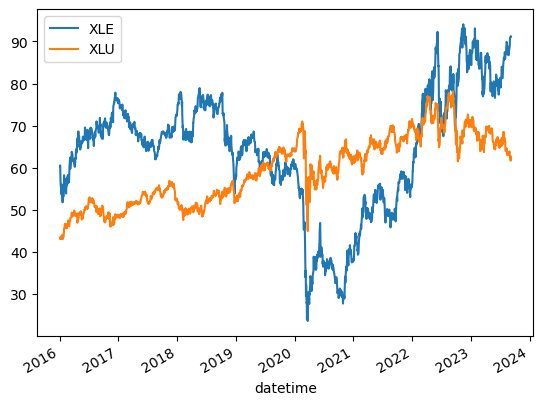

In [13]:
compose[compose.index.year > 2015].plot()

In [16]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(compose.sort_index(), test_size=0.2, shuffle=False)

In [17]:
train_dataset

,XLE,XLU
datetime,,
2010-01-04,58.81,31.08
2010-01-05,59.29,30.71
2010-01-06,60.00,30.89
2010-01-07,59.91,30.75
2010-01-08,60.30,30.72
...,...,...
2020-12-03,38.53,63.04
2020-12-04,40.63,62.41
2020-12-07,39.68,62.76


In [18]:
test_dataset

,XLE,XLU
datetime,,
2020-12-10,41.60,62.14
2020-12-11,41.12,62.24
2020-12-14,39.68,61.92
2020-12-15,40.46,63.14
2020-12-16,40.26,62.41
...,...,...
2023-08-31,88.92,62.96
2023-09-01,90.74,62.64
2023-09-05,91.22,61.68


In [19]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [20]:
def zscore(series):
    return (series - series.mean()) / series.std()

In [26]:
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
def get_info_fold(train_data):
    x = train_data["XLU"]
    y = train_data["XLE"]
    x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()
    x = x["XLU"]
    b = results.params["XLU"]

    spread = y - x * b
    result = ts.adfuller(spread)
    print('ADF Statistic: %f' % result[0])
    
    x = spread.shift().dropna()
    y = spread - spread.shift()
    y = y.dropna()
    x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()
    halflife = -math.log(2) / results.params[0]
    print('Halflife: %f' % halflife)

## RUN ALL FOLDS

In [27]:
for i, (train_index, validation_index) in enumerate(tscv.split(train_dataset)):
    train_data, validation_data = train_dataset.iloc[train_index], train_dataset.iloc[validation_index]
    print(f'--- FOLD {i} ---')
    get_info_fold(train_data)

--- FOLD 0 ---
ADF Statistic: -1.315051
Halflife: 82.551929
--- FOLD 1 ---
ADF Statistic: -2.375030
Halflife: 87.145427
--- FOLD 2 ---
ADF Statistic: -2.372884
Halflife: 118.079188
--- FOLD 3 ---
ADF Statistic: -1.792318
Halflife: 180.562308
--- FOLD 4 ---
ADF Statistic: -2.238871
Halflife: 154.170800


## RUN for each fold

In [28]:
last_fold =  list(tscv.split(train_dataset))[-1]
(train_index, validation_index) = last_fold
train_data, validation_data = train_dataset.iloc[train_index], train_dataset.iloc[validation_index]

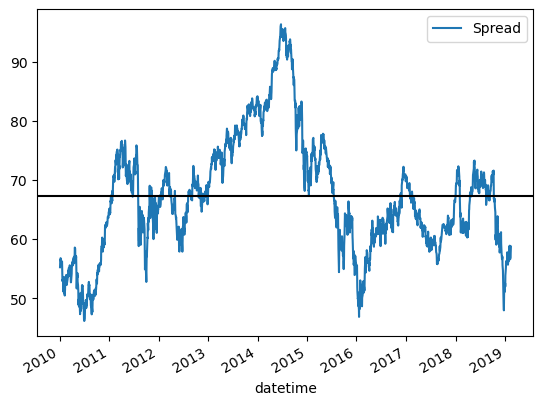

In [29]:
import statsmodels.api as sm

x = train_data["XLU"]
y = train_data["XLE"]
x = sm.add_constant(x)
results = sm.OLS(y, x).fit()
x = x["XLU"]
b = results.params["XLU"]

spread = y - x * b
spread.plot()
plt.axhline(spread.mean(), color="black")
plt.legend(["Spread"]);

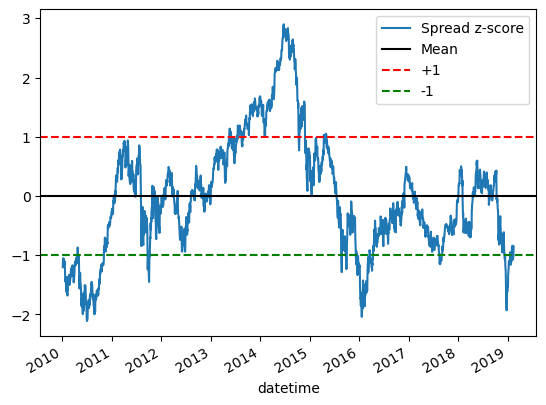

In [30]:
zscore_spread = zscore(spread)
zscore_spread.plot()
plt.axhline(zscore_spread.mean(), color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["Spread z-score", "Mean", "+1", "-1"]);

In [31]:
import statsmodels.tsa.stattools as ts

result = ts.adfuller(spread)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.238871
p-value: 0.192441
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [32]:
spread

datetime
2010-01-04    55.284240
2010-01-05    55.806213
2010-01-06    56.495794
2010-01-07    56.421676
2010-01-08    56.815079
                ...    
2019-02-08    56.623580
2019-02-11    56.925849
2019-02-12    57.711102
2019-02-13    58.529252
2019-02-14    58.769462
Length: 2295, dtype: float64

In [33]:
spread.shift().dropna()

datetime
2010-01-05    55.284240
2010-01-06    55.806213
2010-01-07    56.495794
2010-01-08    56.421676
2010-01-11    56.815079
                ...    
2019-02-08    56.940806
2019-02-11    56.623580
2019-02-12    56.925849
2019-02-13    57.711102
2019-02-14    58.529252
Length: 2294, dtype: float64

In [34]:
x = spread.shift().dropna()
y = spread - spread.shift()
y = y.dropna()
x = sm.add_constant(x)
results = sm.OLS(y, x).fit()

In [35]:
halflife = -math.log(2) / results.params[0]
halflife

154.17080036255135

In [36]:
price = validation_data

In [37]:
price

,XLE,XLU
datetime,,
2019-02-15,66.12,55.71
2019-02-19,66.32,56.04
2019-02-20,66.60,56.29
2019-02-21,65.57,56.70
2019-02-22,65.76,57.05
...,...,...
2020-12-03,38.53,63.04
2020-12-04,40.63,62.41
2020-12-07,39.68,62.76


In [38]:
weights = pd.DataFrame({
    "XLE": [1] * len(price),
    "XLU": [-b] * len(price)
}, index=price.index)
weights

,XLE,XLU
datetime,,
2019-02-15,1,-0.113441
2019-02-19,1,-0.113441
2019-02-20,1,-0.113441
2019-02-21,1,-0.113441
2019-02-22,1,-0.113441
...,...,...
2020-12-03,1,-0.113441
2020-12-04,1,-0.113441
2020-12-07,1,-0.113441


In [39]:
spread = (price * weights).sum(axis=1)
spread

datetime
2019-02-15    59.800177
2019-02-19    59.962741
2019-02-20    60.214381
2019-02-21    59.137870
2019-02-22    59.288165
                ...    
2020-12-03    31.378651
2020-12-04    33.550119
2020-12-07    32.560415
2020-12-08    33.171969
2020-12-09    33.274447
Length: 459, dtype: float64

In [40]:
lookback = round(halflife)
lookback

154

In [41]:
num_units = -(spread - spread.rolling(lookback).mean()) / (spread.rolling(lookback).std())
num_units

datetime
2019-02-15         NaN
2019-02-19         NaN
2019-02-20         NaN
2019-02-21         NaN
2019-02-22         NaN
                ...   
2020-12-03   -0.659784
2020-12-04   -1.203352
2020-12-07   -0.950043
2020-12-08   -1.100338
2020-12-09   -1.115678
Length: 459, dtype: float64

In [42]:
num_units.describe()

count    306.000000
mean       1.120745
std        1.114266
min       -1.203352
25%        0.490493
50%        0.821543
75%        1.585637
max        5.434669
dtype: float64

<Axes: xlabel='datetime'>

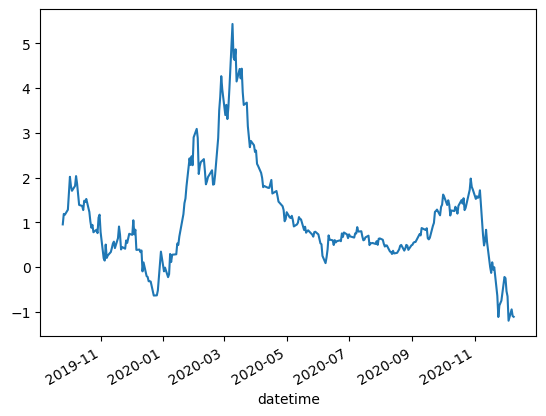

In [102]:
num_units.plot()

In [43]:
positions = weights.mul(num_units, axis=0) * price
positions

,XLE,XLU
datetime,,
2019-02-15,NaN,NaN
2019-02-19,NaN,NaN
2019-02-20,NaN,NaN
2019-02-21,NaN,NaN
2019-02-22,NaN,NaN
...,...,...
2020-12-03,-25.421486,4.718347
2020-12-04,-48.892195,8.519589
2020-12-07,-37.697721,6.763915


<Axes: xlabel='datetime'>

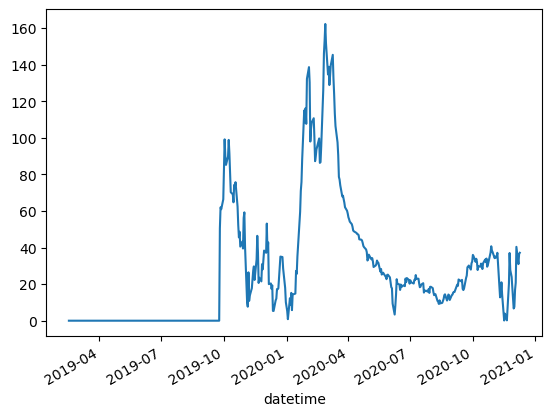

In [106]:
positions.sum(axis=1).abs().plot()

In [44]:
pnl = positions.shift(1) * (price - price.shift(1)) / price.shift(1)
pnl = pnl.sum(axis=1)

In [45]:
pnl.describe()

count    459.000000
mean      -0.134372
std        2.603049
min      -32.576292
25%       -0.183873
50%        0.000000
75%        0.087308
max       11.877455
dtype: float64

In [46]:
ret = pnl / positions.sum(axis=1).abs()
ret

datetime
2019-02-15         NaN
2019-02-19         NaN
2019-02-20         NaN
2019-02-21         NaN
2019-02-22         NaN
                ...   
2020-12-03   -0.012465
2020-12-04   -0.035487
2020-12-07    0.038500
2020-12-08   -0.015918
2020-12-09   -0.003037
Length: 459, dtype: float64

In [47]:
ret.describe()

count    306.000000
mean       0.038613
std        0.601462
min       -0.224156
25%       -0.014060
50%       -0.001370
75%        0.017816
max       10.490798
dtype: float64

<Axes: xlabel='datetime'>

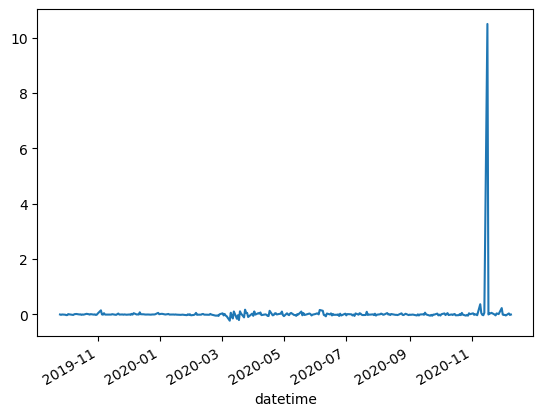

In [48]:
ret.plot()

In [88]:
ret.loc[:ret.idxmax()].tail(5)

datetime
2020-11-10     0.054219
2020-11-11    -0.011891
2020-11-12    -0.026873
2020-11-13     0.064348
2020-11-16    10.490798
dtype: float64

In [73]:
ret.loc[ret.idxmax():].head(5)

datetime
2020-11-16    10.490798
2020-11-17    -0.000526
2020-11-18     0.042217
2020-11-19     0.038037
2020-11-20     0.059425
dtype: float64

In [89]:
pnl.loc[:ret.idxmax()].tail(5)

datetime
2020-11-10    0.692421
2020-11-11   -0.181562
2020-11-12   -0.563747
2020-11-13    0.926803
2020-11-16    1.175930
dtype: float64

In [87]:
pnl.loc[ret.idxmax():].head(5)

datetime
2020-11-16    1.175930
2020-11-17   -0.002037
2020-11-18    0.121994
2020-11-19    0.067015
2020-11-20    0.011695
dtype: float64

In [101]:
num_units.loc[:ret.idxmax()].tail(5)

datetime
2020-11-10    0.479865
2020-11-11    0.582012
2020-11-12    0.830273
2020-11-13    0.545930
2020-11-16   -0.003928
dtype: float64

In [100]:
num_units.loc[ret.idxmax():].head(5)

datetime
2020-11-16   -0.003928
2020-11-17   -0.133357
2020-11-18    0.102688
2020-11-19   -0.061190
2020-11-20   -0.006881
dtype: float64